This notebook shows how to use JOINT to cluster data with 2 cell types and 2 features (genes)

In [1]:
import numpy as np
from joint import joint
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score
%matplotlib inline

/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# generate mixture of zero inflated negative binomial random variables

np.random.seed(12345)

K = 2 # number of cell types
G = 2 # number of genes
L = 2 # number of negative binomial components + 1

b = 1.0
A = [[5,10],[20,30]]
P = []
for a in A:
    t = []
    for x in a:
        t.append([x,b])
    P.append(t)
P = np.array(P)

ks = np.array(range(K))
pi = np.array([0.4,0.6])

th = 0.1

C = 5000 # number of cells
xs = []
x0s = []
ck = []
for i in range(C):
    ys = []
    y0s = []
    k=np.random.choice(ks,p=pi)
    ck.append(k)
    for n in range(G):
        la = np.random.gamma(P[k,n,0], P[k,n,1])
        s = np.random.poisson(la)
        t = np.random.rand()
        y = s*(t>th)
        ys.append(y)
        y0s.append(s)
    xs.append(ys)
    x0s.append(y0s)
x0 = np.array(xs).T
x0s = np.array(x0s).T
ck = np.array(ck)
labels = ck

In [3]:
def kmeans_fit(x, K, n_iter = 100):
    min_cost = np.inf
    min_kmeans = None
    for ii in range(n_iter):
        kmeans = KMeans(n_clusters=K).fit(x)
        if kmeans.inertia_ < min_cost:
            min_cost = kmeans.inertia_
            min_kmeans = kmeans
    return min_kmeans

In [4]:
sol_joint = joint.joint(x0, K, L, n_inits=2, n_init_iter=1,normalize_data=False)

generate center inits
start em algorithm
working on init number 0
working on init number 1
working on init number 2
working on init number 3
working on init number 4
working on init number 5
working on init number 6
working on init number 7
start imputation
working on cluster 0 imputation
working on cluster 1 imputation


Labels from the EM algorithm via hard decision by assigning each individual cell to the cell-type with the highest posterior probability

In [5]:
em_labels = np.argmax(sol_joint['rho'],axis=1).flatten()
adjusted_rand_score(labels, em_labels)

0.8976729715003018

Best K-Means using original data (without dropouts) after running 100 times

In [6]:
kmeans = kmeans_fit(x0s.T, K, 100)
adjusted_rand_score(labels, kmeans.labels_)

0.8849389016833942

This shows that JOINT can sometimes achieve a higher adjusted rand score than K-Means with original data without dropouts

Best K-Means using observed data (with dropouts) after running 100 times

In [7]:
kmeans = kmeans_fit(x0.T, K, 100)
observed_nonlog_labels = kmeans.labels_
adjusted_rand_score(labels, observed_nonlog_labels)

0.6431233093440704

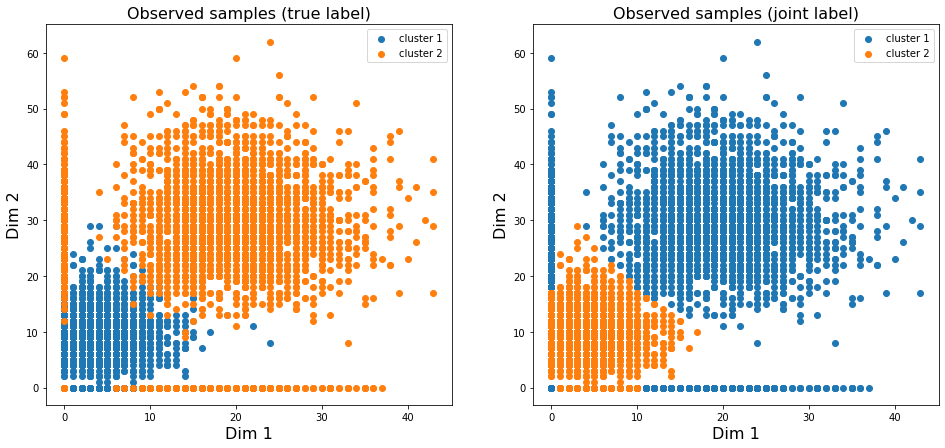

In [8]:
legends = ['cluster 1', 'cluster 2']

fig, axs = plt.subplots(1, 2,figsize=(16,7))
for k in range(K):
    idx = np.where(labels==k)[0]
    axs[0].scatter(x0[0,idx],x0[1,idx], label=legends[k])
axs[0].set_xlabel('Dim 1', fontsize=16)
axs[0].set_ylabel('Dim 2', fontsize=16)
axs[0].set_title('Observed samples (true label)', fontsize=16)
axs[0].legend()

for k in range(K):
    idx = np.where(em_labels.flatten()==k)[0]
    axs[1].scatter(x0[0,idx],x0[1,idx], label=legends[k])
axs[1].set_xlabel('Dim 1', fontsize=16)
axs[1].set_ylabel('Dim 2', fontsize=16)
axs[1].set_title('Observed samples (joint label)', fontsize=16)
axs[1].legend()

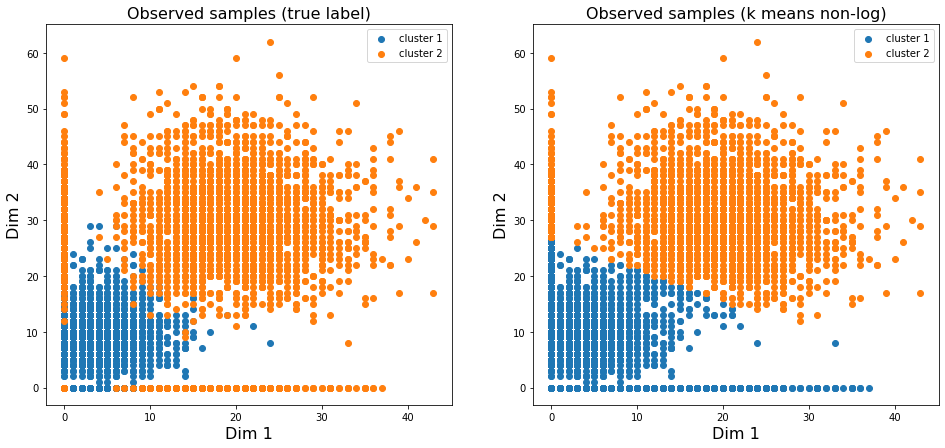

In [9]:
legends = ['cluster 1', 'cluster 2']

fig, axs = plt.subplots(1, 2,figsize=(16,7))
for k in range(K):
    idx = np.where(labels==k)[0]
    axs[0].scatter(x0[0,idx],x0[1,idx], label=legends[k])
axs[0].set_xlabel('Dim 1', fontsize=16)
axs[0].set_ylabel('Dim 2', fontsize=16)
axs[0].set_title('Observed samples (true label)', fontsize=16)
axs[0].legend()

for k in range(K):
    idx = np.where(observed_nonlog_labels==k)[0]
    axs[1].scatter(x0[0,idx],x0[1,idx], label=legends[k])
axs[1].set_xlabel('Dim 1', fontsize=16)
axs[1].set_ylabel('Dim 2', fontsize=16)
axs[1].set_title('Observed samples (k means non-log)', fontsize=16)
axs[1].legend()